<a href="https://colab.research.google.com/github/sadikinisaac/traffic/blob/master/trafficmlxgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving traffic-Encoded.csv to traffic-Encoded.csv


In [0]:
import pandas as pd # the pd is by convention
import numpy as np # as is the np

import matplotlib.pyplot as plt
import seaborn as sns

# To Plot matplotlib figures inline on the notebook
%matplotlib inline

In [0]:
import io
traffic = pd.read_csv(io.BytesIO(uploaded['traffic-Encoded.csv']))

traffic.head()

,holiday,temp,rain_1h,snow_1h,Year,Month,Day,Hour,weather_main,weather_description,traffic_volume
0,5,263.490,0.000,0,2013,1,1,0,1,2,1439
1,6,263.780,0.000,0,2013,1,1,1,1,22,1502
2,6,264.160,0.000,0,2013,1,1,2,7,10,933
3,6,263.950,0.000,0,2013,1,1,3,1,18,576
4,6,263.650,0.000,0,2013,1,1,4,1,18,372


In [0]:
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from xgboost import XGBRegressor, plot_importance 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))




 mu = 3286.76 and sigma = 2028.20



Text(0.5, 1.0, 'Sale Price distribution')

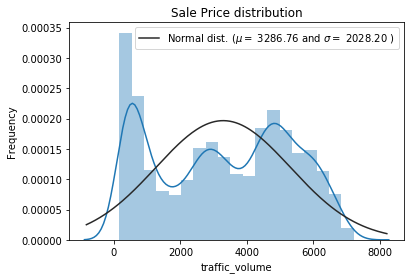

In [0]:

sns.distplot(traffic['traffic_volume'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(traffic['traffic_volume'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Sale Price distribution')

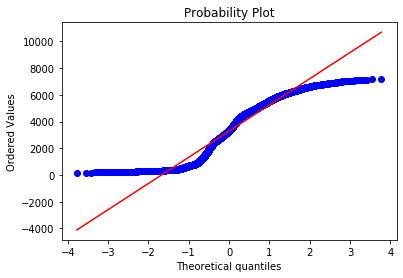

In [0]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(traffic['traffic_volume'], plot=plt)
plt.show();


 mu = 7.76 and sigma = 0.97



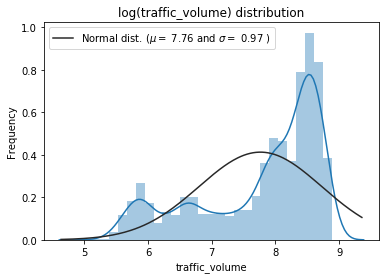

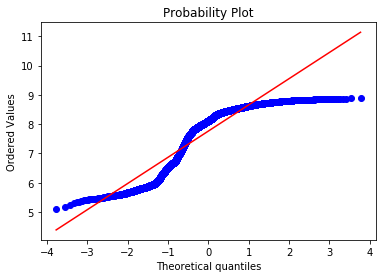

In [0]:
sns.distplot(np.log1p(traffic['traffic_volume']) , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(np.log1p(traffic['traffic_volume']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(traffic_volume) distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(np.log1p(traffic['traffic_volume']), plot=plt)
plt.show()

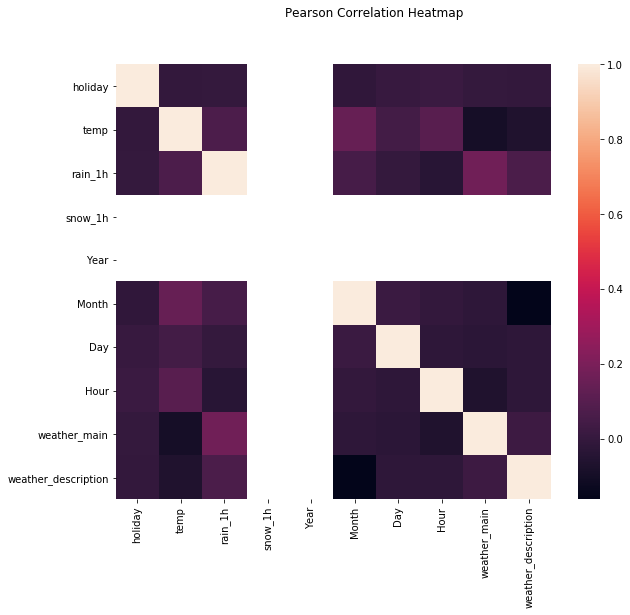

In [0]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(traffic.drop(['traffic_volume'],axis=1).corr(), square=True)
plt.suptitle("Pearson Correlation Heatmap")
plt.show();

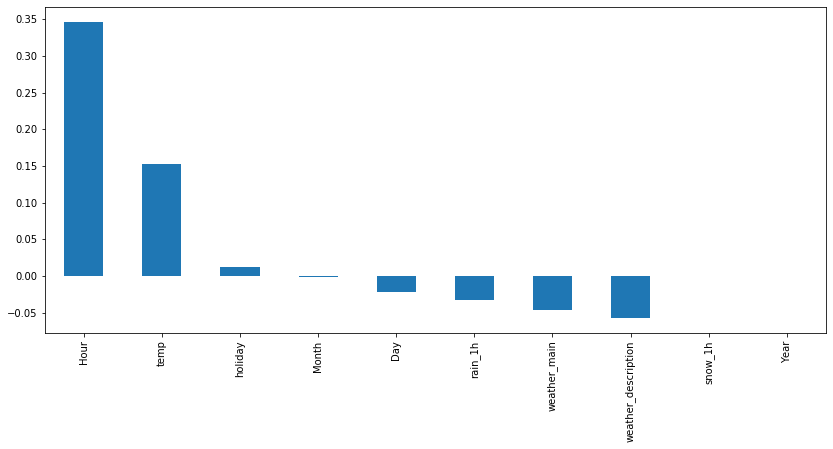

In [0]:
corr_with_traffic_volume = traffic.corr()["traffic_volume"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_traffic_volume.drop("traffic_volume").plot.bar()
plt.show();

In [0]:
#The correlation of traffic volume with hour is 
#the greatest (around 0.35). 
#Also temp presents a correlation of over 0.15

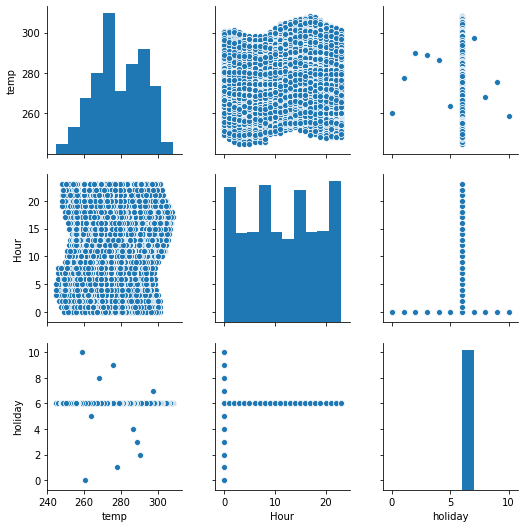

In [0]:
sns.pairplot(traffic[['temp', 'Hour', 'holiday']])
plt.show();

In [0]:
traffic["traffic_volume"] = np.log1p(traffic["traffic_volume"])

#log transform skewed numeric features:
numeric_feats = traffic.dtypes[traffic.dtypes != "object"].index

skewed_feats = traffic[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

traffic[skewed_feats] = np.log1p(traffic[skewed_feats])

In [0]:
traffic = pd.get_dummies(traffic)
traffic = traffic.fillna(traffic.mean())

In [0]:
X, y = traffic.drop(['traffic_volume'], axis = 1), traffic['traffic_volume']

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [0]:
#ElasticNetCV

cv_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

In [0]:
cv_model.fit(X_train, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=6, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=2000,
             n_alphas=100, n_jobs=-1, normalize=True, positive=False,
             precompute='auto', random_state=0, selection='cyclic', tol=0.0001,
             verbose=0)

In [0]:
print('Optimal alpha: %.8f'%cv_model.alpha_)
print('Optimal l1_ratio: %.3f'%cv_model.l1_ratio_)
print('Number of iterations %d'%cv_model.n_iter_)

Optimal alpha: 0.00004929
Optimal l1_ratio: 1.000
Number of iterations 5


In [0]:
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  -1.6109197278797867
Test r2 score:  0.26285695888723226
Train RMSE: 0.8200
Test RMSE: 0.8264


6 features, reduction of 40.00%


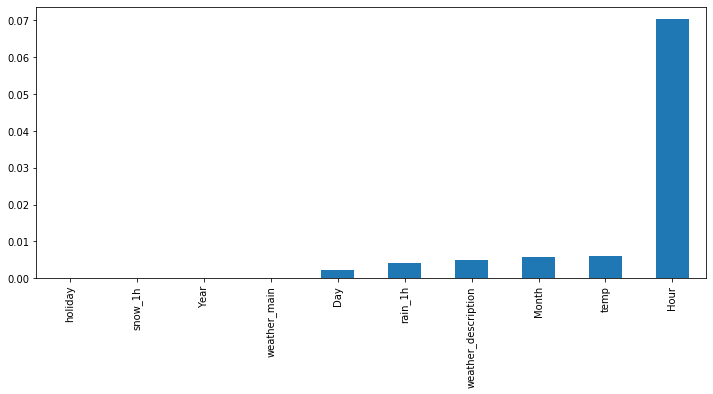

In [0]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(cv_model.coef_))

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

feature_importance.sort_values().tail(30).plot(kind = 'bar', figsize = (12,5));

In [0]:
xgb_model1 = XGBRegressor()
xgb_model1.fit(X_train, y_train, verbose=False)

[06:24:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

Train r2 score:  0.8501963864280849
Test r2 score:  0.873835734793653
Train RMSE: 0.3450
Test RMSE: 0.3419


In [0]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

[06:24:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.8500937076473608
Test r2 score:  0.8738482626335604
Train RMSE: 0.3451
Test RMSE: 0.3419


In [0]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

[06:24:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.8701047889420921
Test r2 score:  0.8799387296255623
Train RMSE: 0.3241
Test RMSE: 0.3335


In [0]:
xgb_model4 = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                         colsample_bytree=1, max_depth=7, n_jobs=-1)
xgb_model4.fit(X_train,y_train)
y_train_pred4 = xgb_model4.predict(X_train)
y_pred4 = xgb_model4.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred4, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred4))
train_mse4 = mean_squared_error(y_train_pred4, y_train)
test_mse4 = mean_squared_error(y_pred4, y_test)
train_rmse4 = np.sqrt(train_mse4)
test_rmse4 = np.sqrt(test_mse4)
print('Train RMSE: %.4f' % train_rmse4)
print('Test RMSE: %.4f' % test_rmse4)

[06:06:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9357061131226534
Test r2 score:  0.899952135283443
Train RMSE: 0.2316
Test RMSE: 0.3044


In [0]:
from collections import OrderedDict
OrderedDict(sorted(xgb_model2.get_booster().get_fscore().items(), key=lambda t: t[1], reverse=True))

OrderedDict([('Hour', 260),
             ('temp', 159),
             ('Day', 109),
             ('Month', 49),
             ('rain_1h', 46),
             ('weather_main', 35),
             ('weather_description', 23),
             ('holiday', 12)])

In [0]:
most_relevant_features= list( dict((k, v) for k, v in xgb_model2.get_booster().get_fscore().items() if v >= 4).keys())
print(most_relevant_features)

['Hour', 'rain_1h', 'weather_main', 'temp', 'Month', 'Day', 'weather_description', 'holiday']


In [0]:
train_x=traffic[most_relevant_features]
train_y=traffic['traffic_volume']
X_train, X_test, y_train, y_test  = train_test_split(train_x, train_y, test_size = 0.2, random_state = 0)

In [0]:
xgb_model5 = XGBRegressor(n_estimators=1000)
xgb_model5.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred5 = xgb_model5.predict(X_train)
y_pred5 = xgb_model5.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred5, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred5))
train_mse5 = mean_squared_error(y_train_pred5, y_train)
test_mse5 = mean_squared_error(y_pred5, y_test)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
print('Train RMSE: %.4f' % train_rmse5)
print('Test RMSE: %.4f' % test_rmse5)

[06:07:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.8500937076473608
Test r2 score:  0.8738482626335604
Train RMSE: 0.3451
Test RMSE: 0.3419


In [0]:
#before XGBoost  
#Train r2 score:  -1.6109197278797867
#Test r2 score:  0.26285695888723226


#after XGBoost especially for XGBoost4   
#with n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                         colsample_bytree=1, max_depth=7, n_jobs=-1
#Train r2 score:  0.9357061131226534
#Test r2 score:  0.899952135283443
#XGBoost creates the weightage of each feature to make the linear regression to make the target (traffic_volume) prediction more accurate
